In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.isomorphism as iso
import scipy.io as sio
import numpy as np
import csv
import time

#Variables Globales

In [17]:
n_segundos=0

#Graficar Grafo

In [18]:
def graficar_grafo(G):
    for i, layer in enumerate(nx.topological_generations(G)):
        for n in layer:
            G.nodes[n]["layer"] = i
    pos_nodes = nx.multipartite_layout(G, subset_key="layer", align="horizontal")
    # Flip the layout so the root node is on top
    for k in pos_nodes:
        pos_nodes[k][-1] *= -1

    color_map = []
    for node in G:
        if G.nodes[node]['tipo']=='MP':
            color_map.append('lime')
        else: 
            color_map.append("deepskyblue")

    options = {
    "font_size": 10,
    "node_size": 400,
    #"node_height":80,
    #"node_width":40,
    "node_shape":"s",
    #"node_color": "red",
    "alpha":0.8,
    "font_weight":"bold",
    "edgecolors": "blue",
    "linewidths": 0.5,
    "width": 1,
    }
    
    plt.figure()
    nx.draw(G, pos=pos_nodes,node_color=color_map, with_labels=True,**options)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] - 0.12)

    node_attrs = nx.get_node_attributes(G, 'operacion')
    custom_node_attrs = {}
    for node, attr in node_attrs.items():
      custom_node_attrs[node] = " (" + attr + ")"  

    nx.draw_networkx_labels(G, pos_attrs,font_size=8, labels=custom_node_attrs)
    
    #plt.text(pos_attrs,"Grafi")
    plt.show()

# Esperar



In [19]:
def esperar(tiempo_espera):
  global n_segundos
  tiempo_espera=int(tiempo_espera)
  time.sleep(tiempo_espera)
  n_segundos += tiempo_espera
  m, s = divmod(n_segundos, 60)
  min_sec_format = '{:02d}:{:02d}'.format(m, s)
  print(min_sec_format, end="  ")

#Narrar

In [20]:
def narrar(nodo,G):
  predecesor=list(G.predecessors(nodo))[0]

  if(G.nodes[nodo]['tipo'] =='MP'):
    print("Envio el/la "+ nodo + " a la estación Nº:"+ str( G.nodes[predecesor]['n_estacion']) )
    esperar(G.nodes[nodo]['t_almacen'])

  if(G.nodes[nodo]['tipo'] =='P'):
    print("Realizo la operación "+str( G.nodes[nodo]['operacion'])+" y envio el "+ nodo +" a la estación Nº:"+ str(G.nodes[predecesor]['n_estacion']))
    esperar(G.nodes[nodo]['t_procesado'])
    if(G.nodes[predecesor]['n_estacion']==100):
      print("Producto terminado")
      global n_segundos
      n_segundos=0


#Cargar Grafo

In [21]:
def cargar_grafo(producto):
    with open('BD Grafos.csv') as File:
        reader = csv.reader(File, delimiter=',', quotechar=',',quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            if row[0]==producto:
              aristas_nodos=[None] * int(0.5*len(row))
              for j in range(0,-1+len(row),2):
                  aristas_nodos[int(j/2)]=(row[j],row[j+1])
    G= nx.from_edgelist(aristas_nodos, create_using=nx.DiGraph)
    lista_nodos=list(G.nodes)
    for nodo in lista_nodos:
          if nodo==lista_nodos[0]:
              G.add_node(nodo, tipo='P', n_estacion=100,operacion='exibir')
          else:
              if nodo[0]+nodo[1]+nodo[2]+nodo[3]=="SubP":
                with open('BD SubProductos.csv') as File:
                  reader = csv.reader(File, delimiter=',', quotechar=',',quoting=csv.QUOTE_MINIMAL)
                  for row in reader:
                        if row[0]==nodo:
                            G.add_node(nodo, tipo='P',operacion=row[1],n_estacion=row[2],t_procesado=row[3],t_estacion=row[4])
              else:
                #print(nodo)
                with open('BD Materias Primas.csv') as File:
                  reader = csv.reader(File, delimiter=',', quotechar=',',quoting=csv.QUOTE_MINIMAL)
                  for row in reader:
                        if row[0]==nodo:
                            G.add_node(nodo, tipo='MP',n_almacen=row[1],t_almacen=row[2])
    return G

#Ejecutar Grafo


In [22]:
def ejecutar_grafo(G):
    caminito_mas_largo=nx.dag_longest_path(G)

    m, s = divmod(0, 60)
    min_sec_format = '{:02d}:{:02d}'.format(m, s)
    print(min_sec_format, end="  ")

    for n in range(len(caminito_mas_largo)-1,0,-1):
      estrctura_recorrido(caminito_mas_largo[n],G)

#Estructura recorrido 2

In [23]:
def estrctura_recorrido2(n_de_partida,G):
  list(G.predecessors(n_de_partida))
  precedente=list(G.predecessors(n_de_partida))[0]
  #print("Envio la " + n_de_partida)
  narrar(n_de_partida,G)
  sucesores=list(G.successors(precedente))
  for i in sucesores:
    if (i!=n_de_partida):
      T = nx.dfs_tree(G, i)
      camino_mas_largo=nx.dag_longest_path(T)
      
      if( len(camino_mas_largo)==2):
        for k in list(G.successors(i)):
          #print("Envio "+ k)
          narrar(k,G)

      if( len(camino_mas_largo) > 2):
        elemento_final2=camino_mas_largo[-1+len(camino_mas_largo)]
        for j in list(G.successors( list(G.predecessors(elemento_final2))[0] )) :
          #print("Envio-- "+ j)
          narrar(j,G)
          
      T.clear()  
      #print("Envio el " + i  )
      narrar(i,G)

#Estructura recorrido

In [24]:
def estrctura_recorrido(n_de_partida,G):
  list(G.predecessors(n_de_partida))
  precedente=list(G.predecessors(n_de_partida))[0]
  #print("Envio la " + n_de_partida)
  narrar(n_de_partida,G)
  sucesores=list(G.successors(precedente))
  for i in sucesores:
    if (i!=n_de_partida):
      T = nx.dfs_tree(G, i)
      camino_mas_largo=nx.dag_longest_path(T)
      
      if( len(camino_mas_largo)==2):
        for k in list(G.successors(i)):
          #print("Envio "+ k)
          narrar(k,G)

      if( len(camino_mas_largo) > 2):
        elemento_final=camino_mas_largo[-1+len(camino_mas_largo)]
        for j in list(G.successors( list(G.predecessors(elemento_final))[0] )) :
            #print("Envio-- "+ j)
            narrar(j,G)
        estrctura_recorrido2( list(G.predecessors(elemento_final))[0] ,G )
        
      T.clear()  
      #print("Envio el " + i  )
      narrar(i,G)

#Entorno de ejecución

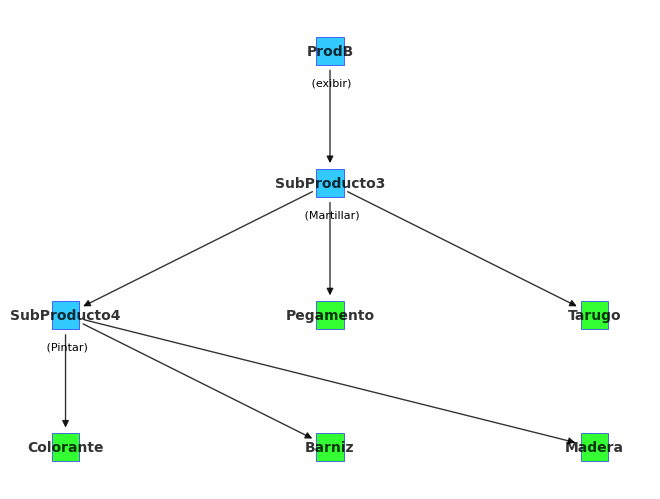

In [27]:
graficar_grafo(cargar_grafo("ProdB"))

In [28]:
ejecutar_grafo(cargar_grafo("ProdB"))

00:00  Envio el/la Madera a la estación Nº:2
00:04  Envio el/la Barniz a la estación Nº:2
00:06  Envio el/la Colorante a la estación Nº:2
00:09  Realizo la operación Pintar y envio el SubProducto4 a la estación Nº:3
00:14  Envio el/la Tarugo a la estación Nº:3
00:17  Envio el/la Pegamento a la estación Nº:3
00:19  Realizo la operación Martillar y envio el SubProducto3 a la estación Nº:100
00:23  Producto terminado
